<a href="https://colab.research.google.com/github/bobbyliujb/FSE/blob/master/bobo_signal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def setup():
  from os.path import exists
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
  cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
  accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
  !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  #!wget -nc -q https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
  #!wget -nc -q https://os.unil.cloud.switch.ch/fma/fma_small.zip
  #!unzip -qu fma_metadata.zip
  #!unzip -qu fma_small.zip
  !apt-get -qq install -y libav-tools
  !apt-get -qq install  -y ffmpeg
  !pip install -q librosa
  print('All Done!')
setup()

All Done!


In [31]:
!apt-get -qq install -y libav-tools

E: Package 'libav-tools' has no installation candidate


In [2]:
# Mount the google drive locally
from google.colab import drive
DRIVE_MOUNT_PATH = '/content/gdrive'
drive.mount(DRIVE_MOUNT_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.rnn as rnn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.autograd import Variable
import pandas as pd
import os
import time
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

In [0]:
ROOT = '/content/gdrive/Team Drives/mlsp/fma/'

In [15]:
features = pd.read_csv(ROOT + 'fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
genres = pd.read_csv(ROOT + 'fma_metadata/genres.csv', index_col=0)
# echonest = pd.read_csv('fma_metadata/echonest.csv', index_col=0, header=[0, 1, 2]) 
tracks = pd.read_csv(ROOT + 'fma_metadata/tracks.csv', index_col=0, header=[0, 1])
SUBSETS = ('small', 'medium', 'large')
tracks['set', 'subset'] = tracks['set', 'subset'].astype(
        'category', categories=SUBSETS, ordered=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  import sys


In [16]:
subset = tracks['set', 'subset'] <= 'medium'
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'
y_train = tracks.loc[subset & train, ('track', 'genre_top')]
y_test = tracks.loc[subset & test, ('track', 'genre_top')]
y_val = tracks.loc[subset & val, ('track', 'genre_top')]

labels = y_val.unique()


['Experimental' 'Rock' 'Hip-Hop' 'Folk' 'Electronic' 'Country' 'Classical'
 'Old-Time / Historic' 'Pop' 'International' 'Jazz' 'Instrumental' 'Blues'
 'Spoken' 'Easy Listening' 'Soul-RnB']


In [88]:
print((tracks.loc[subset & train, ('track', 'genre_top')]).where(lambda x : x == 'Jazz').dropna())
features_mfcc = features.loc[subset & train, ['mfcc']]
scaler = sklearn.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(features_mfcc)

track_id
237       Jazz
590       Jazz
591       Jazz
592       Jazz
593       Jazz
831       Jazz
832       Jazz
833       Jazz
834       Jazz
835       Jazz
1022      Jazz
1023      Jazz
1058      Jazz
1059      Jazz
1060      Jazz
1061      Jazz
1063      Jazz
1064      Jazz
1151      Jazz
1152      Jazz
1153      Jazz
1154      Jazz
1155      Jazz
1963      Jazz
1964      Jazz
1965      Jazz
1966      Jazz
1967      Jazz
1996      Jazz
4703      Jazz
          ... 
126433    Jazz
126434    Jazz
126435    Jazz
126436    Jazz
126437    Jazz
126438    Jazz
126439    Jazz
126440    Jazz
133421    Jazz
133422    Jazz
133423    Jazz
133424    Jazz
133425    Jazz
133426    Jazz
133427    Jazz
133428    Jazz
133429    Jazz
133430    Jazz
136462    Jazz
142932    Jazz
142933    Jazz
143020    Jazz
143120    Jazz
145099    Jazz
145100    Jazz
145101    Jazz
154428    Jazz
154433    Jazz
154434    Jazz
154435    Jazz
Name: (track, genre_top), Length: 306, dtype: object


(19922, 140)

In [0]:
def plot_waveform(x, sr):
  plt.figure(figsize=(15, 5))
  librosa.display.waveplot(x, sr, alpha=0.8)

In [0]:
def load_mp3_by_id(id):
  track_id = '{:06d}'.format(id)
  file_path = os.path.join(ROOT, 'fma_medium', track_id[0:3], track_id + '.mp3')
  x, sr = librosa.load(file_path)
  return x, sr

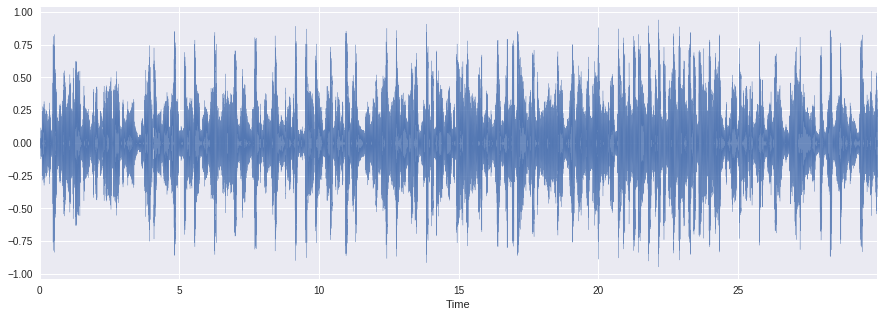

In [33]:
# HipHop
x, sr = load_mp3_by_id(2)
plot_waveform(x, sr)

(1, 140)


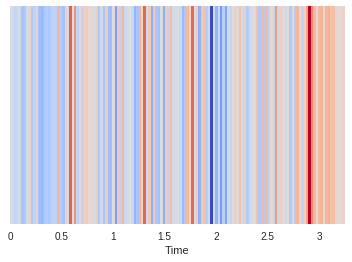

In [95]:
# HipHop
# f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
# temp = librosa.feature.mfcc(x, sr=sr)
# print(temp.shape)
# librosa.display.specshow(temp, sr=sr, x_axis='time')
print(features_mfcc.query('track_id == 2').values.shape)
librosa.display.specshow(features_mfcc.query('track_id == 2').values, sr=sr, x_axis='time')

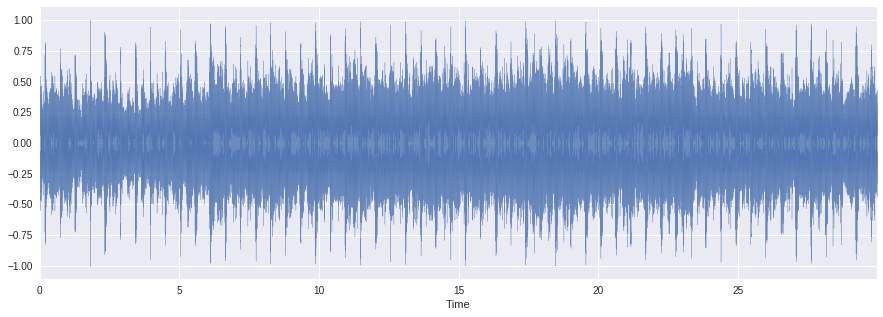

In [34]:
# Pop
x, sr = load_mp3_by_id(10)
plot_waveform(x, sr)

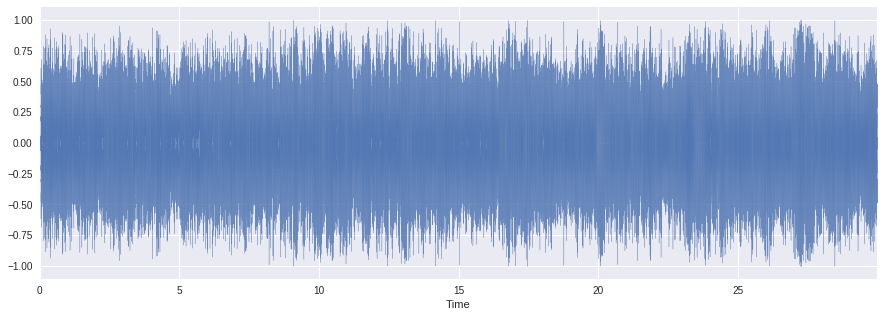

In [35]:
# Rock
x, sr = load_mp3_by_id(136)
plot_waveform(x, sr)

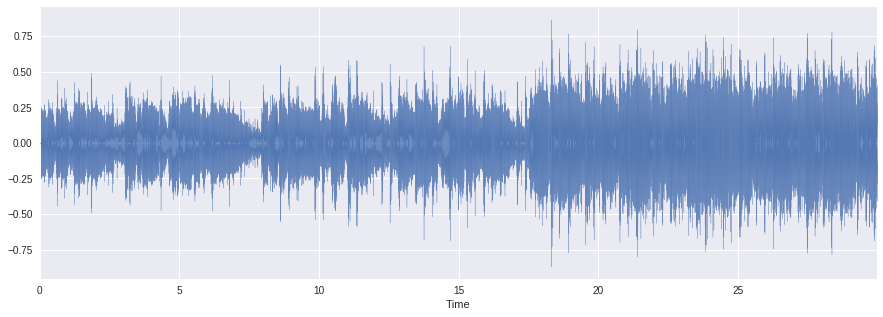

In [36]:
# Folk
x, sr = load_mp3_by_id(139)
plot_waveform(x, sr)

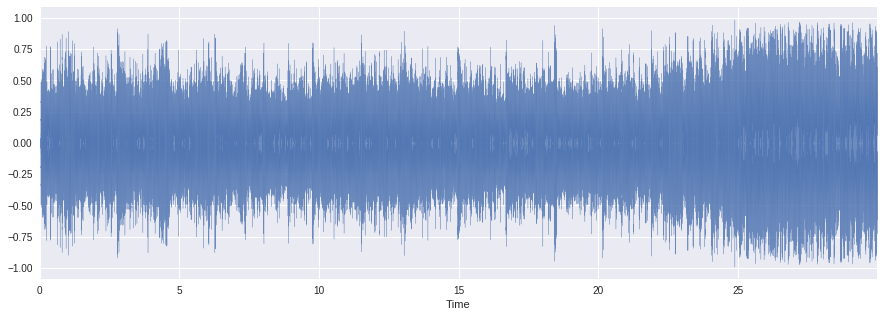

In [37]:
# Jazz
x, sr = load_mp3_by_id(237)
plot_waveform(x, sr)